In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd 
import os,time
from tqdm import tqdm
import random
import shutil

In [27]:
#设置文件目录
train_zip_dir = '/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip'
test_zip_dir = '/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip'
extract_dir = '/kaggle/working/extracted_data'
train_dir = '/kaggle/working/train'
test_dir = '/kaggle/working/test'
os.makedirs(train_dir+'/dog', exist_ok=True)
os.makedirs(train_dir+'/cat', exist_ok=True)
os.makedirs(test_dir+'/test_data', exist_ok=True)

In [28]:
#解压文件
import zipfile
with zipfile.ZipFile(train_zip_dir, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

with zipfile.ZipFile(test_zip_dir, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [29]:
def move_files(train_path,test_path):
    print('Moving Training Files ..')
    time.sleep(1)
    for i in tqdm(os.listdir(train_path)):        
        if 'dog' in i:
            shutil.copyfile(train_path+i,train_dir+'/dog/'+i )
        elif 'cat' in i:
            shutil.copyfile(train_path+i,train_dir+'/cat/'+i )
        else:
            print('unknow File', i)
            
    print('Moving Testing Files ..')
    time.sleep(1)
    for i in tqdm(os.listdir(test_path)):                
        shutil.copyfile(test_path+i, test_dir+'/test_data/'+i)
    shutil.rmtree(extract_dir)
        
move_files(extract_dir+'/train/', extract_dir+'/test/')

Moving Training Files ..


100%|██████████| 25000/25000 [00:02<00:00, 8849.07it/s] 


Moving Testing Files ..


100%|██████████| 12500/12500 [00:01<00:00, 10033.16it/s]


In [30]:
def get_num_files(path):
    if not os.path.exists(path):
        return 0
    return sum([len(files) for r, d, files in os.walk(path)])

In [31]:
train_cat_names = os.listdir(train_dir+"/cat")
train_cat_names[:10]

['cat.6594.jpg',
 'cat.1248.jpg',
 'cat.8535.jpg',
 'cat.1913.jpg',
 'cat.6424.jpg',
 'cat.9905.jpg',
 'cat.10542.jpg',
 'cat.9397.jpg',
 'cat.2837.jpg',
 'cat.12138.jpg']

In [32]:
len(train_cat_names)

12500

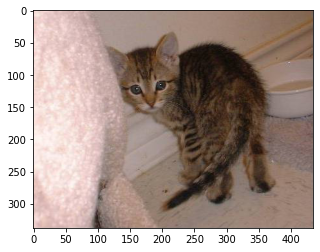

In [33]:
#可爱的小猫猫
sample = random.choice(train_cat_names)
plt.imshow(plt.imread(train_dir+'/cat/'+sample))

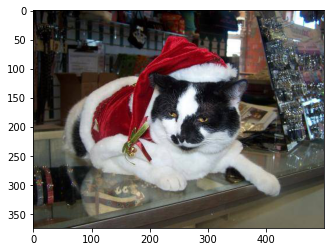

In [34]:
sample = random.choice(train_cat_names)
plt.imshow(plt.imread(train_dir+'/cat/'+sample))

In [35]:
from keras.preprocessing.image import ImageDataGenerator
#把所有图片统一比例
train_datagen = ImageDataGenerator(rescale = 1.0/255.,
                                  validation_split= 0.1)
train_generator = train_datagen.flow_from_directory(
                                                    directory=train_dir,
                                                    seed=7,
                                                    class_mode='categorical',
                                                    subset='training',
                                                    target_size=(300, 300)) 
validation_generator = train_datagen.flow_from_directory(
                                                    directory = train_dir,
                                                    seed = 7,
                                                    subset='validation',
                                                    class_mode = 'categorical',
                                                    target_size = (300, 300))   

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [36]:
from keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard
LR_callback = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=2, factor=.5, min_lr=0.001)
EarlyStop_callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True)
my_callback=[EarlyStop_callback, LR_callback]

In [37]:
#建立模型
InceptionV3_base_model = keras.applications.InceptionV3(weights='imagenet', include_top=False)
x = InceptionV3_base_model.output
x_pool = layers.GlobalAveragePooling2D()(x)
final_pred = layers.Dense(2,activation='softmax')(x_pool)
model = keras.models.Model(inputs=InceptionV3_base_model.input,outputs=final_pred)

In [38]:
layer_to_Freeze=276    
for layer in model.layers[:layer_to_Freeze]:
    layer.trainable =False
for layer in model.layers[layer_to_Freeze:]:
    layer.trainable=True

sgd = keras.optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer=sgd,loss='binary_crossentropy',metrics=['accuracy'])

In [39]:
#训练模型
total_samples = get_num_files(train_dir)
n_train=total_samples*(1-0.1)   #减去0.1的validation
n_val=total_samples*0.1
history_transfer_learning = model.fit(train_generator,
                                                epochs=30,
                                                steps_per_epoch=n_train//32,
                                                validation_data=validation_generator,
                                                validation_steps=n_val//32,
                                                verbose=1,
                                                callbacks=my_callback,
                                                )

Epoch 1/30
703/703 [==============================] - 142s 196ms/step - loss: 0.0587 - accuracy: 0.9849 - val_loss: 0.0188 - val_accuracy: 0.9940
Epoch 2/30
703/703 [==============================] - 134s 191ms/step - loss: 0.0119 - accuracy: 0.9961 - val_loss: 0.0188 - val_accuracy: 0.9944
Epoch 3/30
703/703 [==============================] - 135s 192ms/step - loss: 0.0059 - accuracy: 0.9981 - val_loss: 0.0229 - val_accuracy: 0.9936
Epoch 4/30
703/703 [==============================] - 135s 192ms/step - loss: 0.0112 - accuracy: 0.9967 - val_loss: 0.0188 - val_accuracy: 0.9940
Epoch 5/30
703/703 [==============================] - 135s 192ms/step - loss: 0.0027 - accuracy: 0.9994 - val_loss: 0.0187 - val_accuracy: 0.9932

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
Epoch 6/30
703/703 [==============================] - 136s 194ms/step - loss: 0.0023 - accuracy: 0.9993 - val_loss: 0.0178 - val_accuracy: 0.9952
Epoch 7/30
703/703 [========================

In [40]:
score = model.evaluate(validation_generator,verbose=1)
print('Test loss: ', score[0])
print('Test accuracy', score[1])

79/79 [==============================] - 13s 167ms/step - loss: 0.0202 - accuracy: 0.9960
Test loss:  0.020205629989504814
Test accuracy 0.9959999918937683


In [41]:
test_image_gen = ImageDataGenerator(rescale=1/255)
test_generator = test_image_gen.flow_from_directory(test_dir,target_size=(300,300),batch_size=1,class_mode=None,shuffle=False)

Found 12500 images belonging to 1 classes.


In [43]:
pred = model.predict_generator(generator=test_generator,verbose=1)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


12500/12500 [==============================] - 183s 15ms/step


In [44]:
submission = pd.DataFrame({'id':pd.Series(test_generator.filenames),'label':pd.Series(pred.clip(min=0.02,max=0.98)[:,1])})
submission['id'] = submission.id.str.extract('(\d+)')
submission['id']=pd.to_numeric(submission['id'])
submission.to_csv("MySubmission.csv",index=False)

In [45]:
submission.head(10)

,id,label
0,1,0.98
1,10,0.02
2,100,0.02
3,1000,0.98
4,10000,0.98
5,10001,0.02
6,10002,0.02
7,10003,0.98
8,10004,0.98
9,10005,0.02


In [46]:
submission.to_csv('DogVsCats_submission.csv',index=False)
shutil.rmtree(train_dir)
shutil.rmtree(test_dir)